In [56]:
using DynamicalSystems, DifferentialEquations, OrdinaryDiffEq
using CairoMakie
using SciPy, Statistics

In [54]:
function HR!(du, u, p, t)
    
    function sigma(x)
            return 1.0 / ( 1.0 + exp( -10.0 * ( x  - ( - 0.25 ) ) ) )
    end
    
    a, b, c, d, s, xr, r,  I, vs, k1, k2, el_link  = p
    x1, y1, z1, x2, y2, z2 = u
    
    du[1] = y1 + b * x1 ^ 2 - a * x1 ^3 - z1 + I - k1 * ( x1 - vs ) * sigma(x2) + el_link * ( x2 - x1 )
    du[2] = c - d * x1 ^2 - y1
    du[3] = r * ( s * ( x1 - xr ) - z1 )
    
    du[4] = y2 + b * x2 ^ 2 - a * x2 ^3 - z2 + I - k2 * ( x2 - vs ) * sigma(x1) + el_link * ( x1 - x2 )
    du[5] = c - d * x2 ^2 - y2
    du[6] = r * ( s * ( x2 - xr ) - z2 )
    
    return SVector(du[1], du[2], du[3],
                    du[4], du[5], du[6])
end   

HR! (generic function with 1 method)

In [58]:
function get_variable(tr, Δt_start, choose_variable)
    
    len_ = length(tr[Δt_start:end, 1])
    x = zeros(len_)
    
    for index in choose_variable
        x += tr[Δt_start:end, index]
    end
    return x
end

function threshold_classic(x, k::Int, positive::Bool = true)
    
    if positive
        index = signal.argrelmax( x_sum )[1]
        spikes = [x_sum[x] for x in index]
        Hs = Statistics.mean(spikes) + k * Statistics.std(spikes)
    else
        index = signal.argrelmin( x_sum )[1]
        spikes = [x_sum[x] for x in index]
        Hs = Statistics.mean(spikes) - k * Statistics.std(spikes)
    end
    
    return Hs
    
end

threshold_classic (generic function with 2 methods)

In [13]:
u0 = [-1.5, 0.0, 0.0, -2.5, 0.0, 0.0]
tspan = (0.0, 20000.0)

a = 1.0; b = 3.0; c = 1.0; d = 5.0
xr = -1.6; r = 0.01; s = 5.0; I = 4.0; xv = 2.0
k1= -0.17; k2 = -0.17
k = 0.0;

p = [a, b, c, d, s, xr, r, I, xv, k1, k2, k]
ds_HR = ContinuousDynamicalSystem(HR!, u0, p )

6-dimensional continuous dynamical system
 state:       [-1.5, 0.0, 0.0, -2.5, 0.0, 0.0]
 rule f:      HR!
 in-place?    true
 jacobian:    ForwardDiff
 parameters:  [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, …, 4.0, 2.0, -0.17, -0.17, 0.0]

In [41]:
tr = trajectory(ds_HR, 20000; diffeq = (alg = AutoVern9(Rodas5()),
                                                            abstol = 1e-11, reltol = 1e-11,
                                                            maxiters = 10000000
                                                            ))

6-dimensional Dataset{Float64} with 2000001 points
 -1.5        0.0        0.0          -2.5        0.0        0.0
 -1.36934   -0.0922662  8.35021e-5   -2.17188   -0.259935  -0.000363711
 -1.25641   -0.167023   0.000227692  -1.92455   -0.455251  -0.000585135
 -1.1572    -0.227777   0.000424763  -1.72926   -0.606306  -0.000696758
 -1.06882   -0.277126   0.000668607  -1.56971   -0.725359  -0.000720181
 -0.989179  -0.317049   0.000954352  -1.43593   -0.820336  -0.000670603
 -0.916652  -0.349086   0.00127805   -1.32142   -0.896637  -0.000559182
 -0.850002  -0.374455   0.00163647   -1.22172   -0.9581    -0.000394377
 -0.788252  -0.394142   0.00202691   -1.13369   -1.00754   -0.000182767
 -0.730617  -0.40895    0.00244712   -1.055     -1.04709    7.04157e-5
 -0.676463  -0.419546   0.00289522   -0.983948  -1.07839    0.000360944
 -0.625267  -0.42649    0.00336959   -0.919193  -1.10272    0.000685346
 -0.576593  -0.430258   0.00386886   -0.859714  -1.12113    0.00104073
  ⋮                    

In [59]:
x_sum_test = get_variable(tr, 10000, [1, 4])
Hs = threshold_classic(x_sum_test, 6)

2.1921431609542967

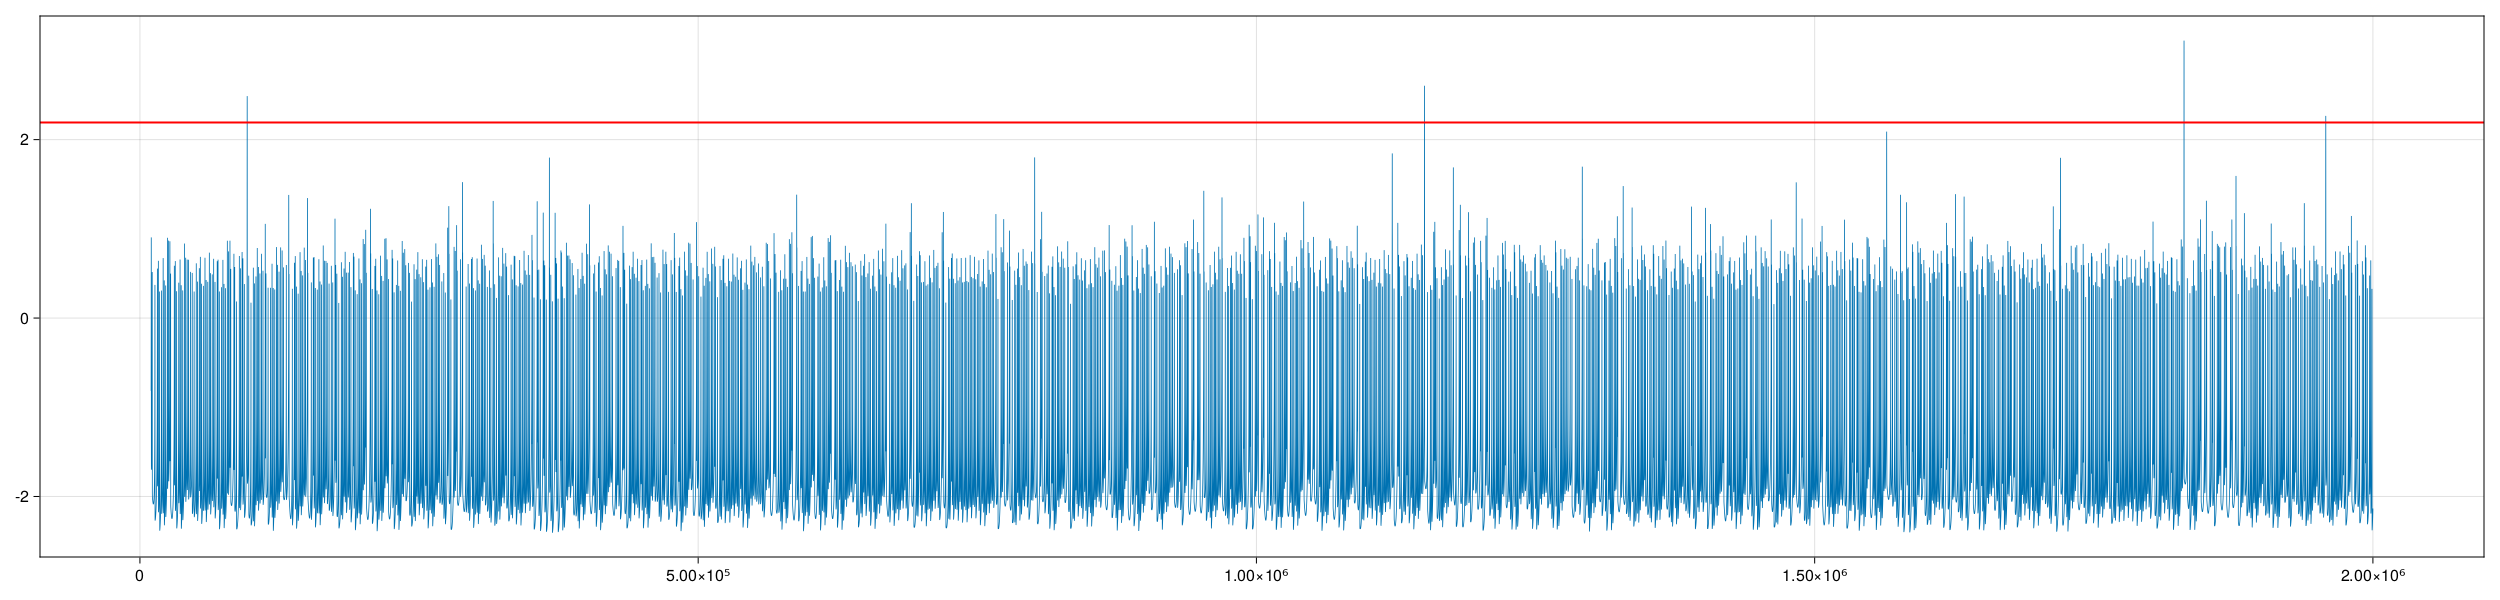

In [62]:
time = range(1, length(tr[:, 1]))

x_sum = (tr[:, 1] + tr[:, 4])[10000:end]
time = time[10000:end]

fig = Figure(resolution = (2500, 600))
lines(fig[1, 1], time, x_sum, linewidth = 0.8)
hlines!(fig[1, 1], Hs, color = "red", linewidth = 2)
fig